# ============================================================
# AE3 - Exercicio 3B - Deslocamentos placa bidimensional engastada + apoio

# Bloco 1 — Importar bibliotecas, parâmetros do problema e hiperparâmetros 
# ========================================================================

In [1]:
# !pip -q install torch matplotlib numpy

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- Problema --------
L  = 1.0
E  = 1.0
nu = 0.3

# constitutivas (tensão plana)
C11 = E/(1.0 - nu**2)
C12 = nu*C11
G   = E/(2.0*(1.0 + nu))

# -------- Hiperparâmetros --------
HIDDEN_LAYERS   = 4
NEURONS_PER_LAY = 64
ACTIVATION_NAME = "tanh"       # 'tanh' | 'relu' | 'silu'

Nf  = 4000                     # interior
Nr  = 1000                     # borda direita x=L
Nt  = 1000                     # borda superior y=L
Nb  = 1000                     # borda inferior y=0 (apoio simples)

LR     = 1e-3
EPOCHS = 12000
USE_LBFGS = True

# pesos na loss
LAMBDA_PDE = 1.0
LAMBDA_R   = 10.0             # x=L
LAMBDA_T   = 10.0             # y=L
LAMBDA_B   = 10.0             # y=0 (σ_xy=0)

# escala para deslocamentos
U_SCALE = 1.0

print("[Config PINN — placa 2D, caso (b)]")
print(f"  Rede: {HIDDEN_LAYERS} camadas × {NEURONS_PER_LAY} neurônios (ativação: {ACTIVATION_NAME})")
print(f"  Pontos: Nf={Nf}, Nr={Nr}, Nt={Nt}, Nb={Nb}")
print(f"  Otimizadores: Adam(lr={LR}){' + L-BFGS' if USE_LBFGS else ''}; Épocas(Adam)={EPOCHS}")
print(f"  Pesos: PDE={LAMBDA_PDE}, x=L={LAMBDA_R}, y=L={LAMBDA_T}, y=0={LAMBDA_B}")
print("  C.C. hard: u=v=0 em x=0; v=0 em y=0 (apoio simples). Trações nas demais bordas: soft.")


[Config PINN — placa 2D, caso (b)]
  Rede: 4 camadas × 64 neurônios (ativação: tanh)
  Pontos: Nf=4000, Nr=1000, Nt=1000, Nb=1000
  Otimizadores: Adam(lr=0.001) + L-BFGS; Épocas(Adam)=12000
  Pesos: PDE=1.0, x=L=10.0, y=L=10.0, y=0=10.0
  C.C. hard: u=v=0 em x=0; v=0 em y=0 (apoio simples). Trações nas demais bordas: soft.


# ======================================================================
# Bloco 2 — PINN (derivadas, ansatz HARD; amostragem com tensores-leaf)

In [2]:
# --- helpers ---
def d(u, xy, i):
    return torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u),
                               create_graph=True, retain_graph=True)[0][:, i:i+1]
def leaf(t): return t.detach().requires_grad_(True)

def make_activation(name):
    name = name.lower()
    if name == "tanh": return nn.Tanh()
    if name == "relu": return nn.ReLU()
    if name == "silu": return nn.SiLU()
    raise ValueError("Ativação inválida.")

# --- MLP básico (2->2) ---
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers, neurons, act_name):
        super().__init__()
        act = make_activation(act_name)
        layers = [nn.Linear(in_dim, neurons), act]
        for _ in range(hidden_layers-1):
            layers += [nn.Linear(neurons, neurons), act]
        layers += [nn.Linear(neurons, out_dim)]
        self.net = nn.Sequential(*layers)
        self.hidden_layers = hidden_layers
        self.neurons = neurons
        self.act_name = act_name
    def forward(self, x): return self.net(x)

# --- Ansatz HARD adequado ao caso (b) ---
# u(x,y) = U_SCALE * x      * f1(ξ,η)  -> zera em x=0 (engaste), livre em y=0
# v(x,y) = U_SCALE * x*y    * f2(ξ,η)  -> zera em x=0 e em y=0 (apoio simples)
class PlatePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = MLP(2, 2, HIDDEN_LAYERS, NEURONS_PER_LAY, ACTIVATION_NAME)
    def forward(self, xy):
        xi_eta = xy / L
        f1f2 = self.f(xi_eta)
        u = U_SCALE * (xy[:,0:1])      * f1f2[:,0:1]
        v = U_SCALE * (xy[:,0:1]*xy[:,1:2]) * f1f2[:,1:2]
        return u, v

net = PlatePINN().to(device)

# resumo
def count_params(m): return sum(p.numel() for p in m.parameters())
print("[Resumo da Rede]")
print(f"  - Arquitetura: entrada(2) -> {[NEURONS_PER_LAY]*HIDDEN_LAYERS} -> saída(2)")
print(f"  - Ativação: {net.f.act_name} | #Parâmetros: {count_params(net):,}")

# --- amostradores (leaf) ---
def sample_interior(N):
    return leaf(torch.rand(N,2,device=device) * L)
def sample_right(N):   # x=L
    y = torch.rand(N,1,device=device) * L
    x = torch.full((N,1), L, device=device)
    return leaf(torch.cat([x,y], dim=1))
def sample_top(N):     # y=L
    x = torch.rand(N,1,device=device) * L
    y = torch.full((N,1), L, device=device)
    return leaf(torch.cat([x,y], dim=1))
def sample_bottom(N):  # y=0
    x = torch.rand(N,1,device=device) * L
    y = torch.zeros(N,1,device=device)
    return leaf(torch.cat([x,y], dim=1))

XY_f = sample_interior(Nf)
XY_r = sample_right(Nr)
XY_t = sample_top(Nt)
XY_b = sample_bottom(Nb)


[Resumo da Rede]
  - Arquitetura: entrada(2) -> [64, 64, 64, 64] -> saída(2)
  - Ativação: tanh | #Parâmetros: 12,802


# ==================================================================================
# Bloco 3 — Perdas, treino (Adam + L-BFGS) e pós-processamento (histórico detalhado)

In [3]:
# ==== BLOCO 4 (corrigido) ====
mse = nn.MSELoss()

def stresses(u, v, xy):
    ux = d(u, xy, 0); uy = d(u, xy, 1)
    vx = d(v, xy, 0); vy = d(v, xy, 1)
    exx = ux; eyy = vy; gxy = uy + vx
    sxx = C11*exx + C12*eyy
    syy = C11*eyy + C12*exx
    sxy = G*gxy
    return sxx, sxy, syy

def pde_residuals(xy):
    u, v = net(xy)
    sxx, sxy, syy = stresses(u, v, xy)
    r1 = d(sxx, xy, 0) + d(sxy, xy, 1)
    r2 = d(sxy, xy, 0) + d(syy, xy, 1)
    return r1, r2

def loss_func():
    # PDE (interior)
    r1, r2 = pde_residuals(XY_f)
    loss_pde = LAMBDA_PDE*(mse(r1, torch.zeros_like(r1)) + mse(r2, torch.zeros_like(r2)))

    # x = L: σxx = sin(pi*y/L), σxy = 0
    ur, vr = net(XY_r)
    sxx_r, sxy_r, _ = stresses(ur, vr, XY_r)
    y_r = XY_r[:,1:2]
    target_sxx = torch.sin(np.pi * y_r / L)
    loss_right = LAMBDA_R*(mse(sxx_r, target_sxx) + mse(sxy_r, torch.zeros_like(sxy_r)))

    # y = L: livre -> σyy = 0, σxy = 0
    ut, vt = net(XY_t)
    _, sxy_t, syy_t = stresses(ut, vt, XY_t)
    loss_top = LAMBDA_T*(mse(syy_t, torch.zeros_like(syy_t)) + mse(sxy_t, torch.zeros_like(sxy_t)))

    # y = 0: apoio simples -> σxy = 0 (v=0 já é HARD no ansatz)
    ub, vb = net(XY_b)
    _, sxy_b, _ = stresses(ub, vb, XY_b)
    loss_bottom = LAMBDA_B*mse(sxy_b, torch.zeros_like(sxy_b))

    loss_total = loss_pde + loss_right + loss_top + loss_bottom
    return loss_total, loss_pde, loss_right, loss_top, loss_bottom

# ---------- Adam ----------
opt = torch.optim.Adam(net.parameters(), lr=LR)
loss_hist, pde_hist, right_hist, top_hist, bottom_hist = [], [], [], [], []

print("[Treino] Adam")
for epoch in range(EPOCHS):
    # reamostra periodicamente (robustez e evita grafos pendurados)
    if epoch % 200 == 0:
        XY_f = sample_interior(Nf)
        XY_r = sample_right(Nr)
        XY_t = sample_top(Nt)
        XY_b = sample_bottom(Nb)

    opt.zero_grad()
    lt, lp, lr_, lt_, lb_ = loss_func()
    lt.backward()
    opt.step()

    # logs (como floats)
    loss_hist.append(lt.detach().cpu().item())
    pde_hist.append(lp.detach().cpu().item())
    right_hist.append(lr_.detach().cpu().item())
    top_hist.append(lt_.detach().cpu().item())
    bottom_hist.append(lb_.detach().cpu().item())

    if (epoch+1) % 1000 == 0:
        print(f"  epoch {epoch+1:5d}: loss={loss_hist[-1]:.3e} | "
              f"pde={pde_hist[-1]:.3e} | x=L={right_hist[-1]:.3e} | "
              f"y=L={top_hist[-1]:.3e} | y=0={bottom_hist[-1]:.3e}")

# ---------- L-BFGS ----------
if USE_LBFGS:
    print("[Treino] L-BFGS (refino)")

    # PONTOS FRESCOS como LEAF antes do L-BFGS (evita o RuntimeError do backward)
    XY_f = sample_interior(Nf)
    XY_r = sample_right(Nr)
    XY_t = sample_top(Nt)
    XY_b = sample_bottom(Nb)

    optimizer = torch.optim.LBFGS(net.parameters(), lr=1.0, max_iter=500,
                                  history_size=50, line_search_fn="strong_wolfe")
    def closure():
        optimizer.zero_grad()
        lt, *_ = loss_func()    # sem detach aqui
        lt.backward()
        return lt
    lbfgs_loss = optimizer.step(closure).item()   # <<< .item() elimina o warning
    print(f"  LBFGS final loss: {lbfgs_loss:.3e}")

# ---------- Pós-processamento (campos u e v) ----------
Nx = Ny = 101
xg = np.linspace(0, L, Nx)
yg = np.linspace(0, L, Ny)
xx, yy = np.meshgrid(xg, yg, indexing='xy')

XYg = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=1),
                   dtype=torch.float32, device=device)

with torch.no_grad():
    ug, vg = net(XYg)
U = ug.reshape(Ny, Nx).cpu().numpy()
V = vg.reshape(Ny, Nx).cpu().numpy()


[Treino] Adam
  epoch  1000: loss=1.800e-01 | pde=6.730e-02 | x=L=6.396e-02 | y=L=4.426e-02 | y=0=4.501e-03
  epoch  2000: loss=7.755e-02 | pde=2.711e-02 | x=L=9.805e-03 | y=L=3.987e-02 | y=0=7.669e-04
  epoch  3000: loss=6.840e-02 | pde=2.264e-02 | x=L=5.734e-03 | y=L=3.950e-02 | y=0=5.301e-04
  epoch  4000: loss=6.624e-02 | pde=2.073e-02 | x=L=5.274e-03 | y=L=3.987e-02 | y=0=3.683e-04
  epoch  5000: loss=6.168e-02 | pde=1.800e-02 | x=L=5.291e-03 | y=L=3.812e-02 | y=0=2.661e-04
  epoch  6000: loss=5.485e-02 | pde=1.641e-02 | x=L=3.414e-03 | y=L=3.480e-02 | y=0=2.207e-04
  epoch  7000: loss=5.222e-02 | pde=1.534e-02 | x=L=2.978e-03 | y=L=3.371e-02 | y=0=1.941e-04
  epoch  8000: loss=4.465e-02 | pde=1.450e-02 | x=L=2.004e-03 | y=L=2.799e-02 | y=0=1.591e-04
  epoch  9000: loss=4.516e-02 | pde=1.414e-02 | x=L=1.940e-03 | y=L=2.891e-02 | y=0=1.761e-04
  epoch 10000: loss=3.823e-02 | pde=1.207e-02 | x=L=1.252e-03 | y=L=2.476e-02 | y=0=1.561e-04
  epoch 11000: loss=3.308e-02 | pde=9.384e-03 

# ===================================================
# Bloco 4 — Gráficos de perdas (componentes e total)

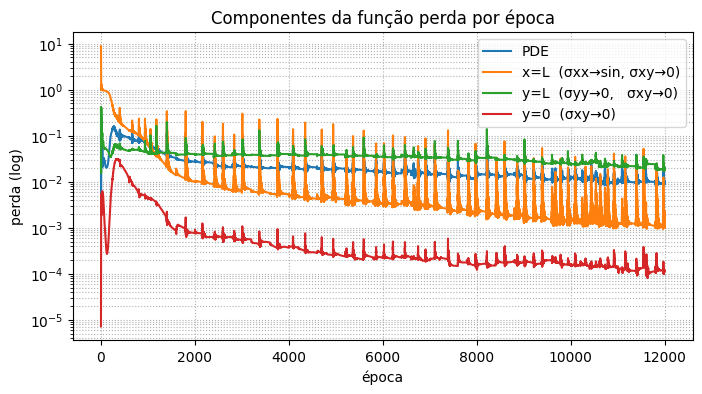

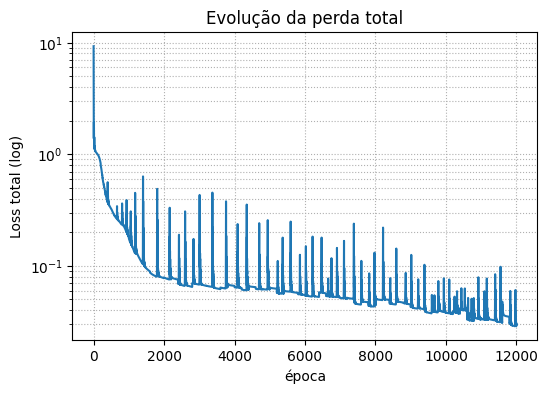

In [4]:
plt.figure(figsize=(8,4))
plt.plot(pde_hist,   label="PDE")
plt.plot(right_hist, label="x=L  (σxx→sin, σxy→0)")
plt.plot(top_hist,   label="y=L  (σyy→0,   σxy→0)")
plt.plot(bottom_hist,label="y=0  (σxy→0)")
plt.yscale("log"); plt.grid(True, which="both", ls=":")
plt.xlabel("época"); plt.ylabel("perda (log)")
plt.title("Componentes da função perda por época")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(loss_hist)
plt.yscale("log"); plt.grid(True, which="both", ls=":")
plt.xlabel("época"); plt.ylabel("Loss total (log)")
plt.title("Evolução da perda total")
plt.show()


# =============================================================
# Bloco 5 — Pós-processamento de contorno (gráficos + métricas)


[Checagem de tração e apoio]
  x=L:  σxx→sin  RMS=5.943e-03,  max|err|=3.891e-02
        σxy→0    RMS=2.988e-03,              max|err|=8.407e-03
  y=L:  σyy→0    RMS=2.557e-02,              max|err|=2.810e-01
        σxy→0    RMS=3.369e-02,              max|err|=3.561e-01
  y=0:  v=0(hard) max|v|=0.000e+00          σxy→0  RMS=2.481e-03, max|err|=7.269e-03


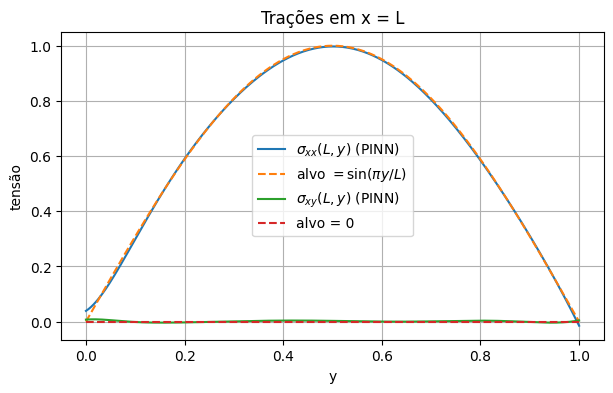

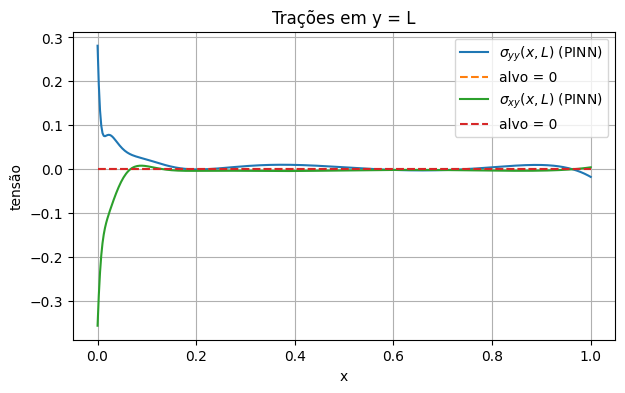

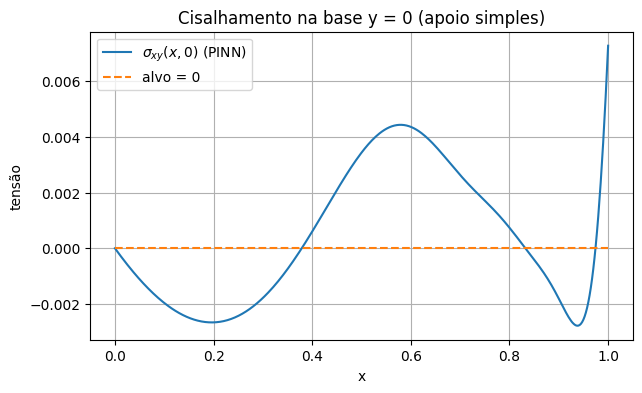

In [6]:
# ==== BLOCO 6 — Pós-processamento de contorno (CORRIGIDO) ====

# Perfis de checagem (pontos como LEAF com grad habilitado)
Ny_chk = 400
y_chk = torch.linspace(0, L, Ny_chk, device=device).view(-1, 1)
XY_right = leaf(torch.cat([torch.full_like(y_chk, L), y_chk], dim=1))   # x = L

Nx_chk = 400
x_chk = torch.linspace(0, L, Nx_chk, device=device).view(-1, 1)
XY_top  = leaf(torch.cat([x_chk, torch.full_like(x_chk, L)], dim=1))   # y = L
XY_bot  = leaf(torch.cat([x_chk, torch.zeros_like(x_chk)], dim=1))     # y = 0

# >>> NÃO usar no_grad aqui: precisamos de autograd para derivadas (tensões)

# x = L  (σxx -> senoidal, σxy -> 0)
ur, vr = net(XY_right)
sxx_r, sxy_r, _ = stresses(ur, vr, XY_right)
sxx_r = sxx_r.detach().cpu().numpy().ravel()
sxy_r = sxy_r.detach().cpu().numpy().ravel()
target_sxx_r = np.sin(np.pi * y_chk.cpu().numpy().ravel() / L)

# y = L  (livre: σyy -> 0, σxy -> 0)
ut, vt = net(XY_top)
_, sxy_t, syy_t = stresses(ut, vt, XY_top)
syy_t = syy_t.detach().cpu().numpy().ravel()
sxy_t = sxy_t.detach().cpu().numpy().ravel()

# y = 0  (apoio simples sem atrito: v = 0 (HARD) e σxy -> 0 (SOFT))
ub, vb = net(XY_bot)
_, sxy_b, _ = stresses(ub, vb, XY_bot)
sxy_b = sxy_b.detach().cpu().numpy().ravel()
vb_   = vb.detach().cpu().numpy().ravel()   # deve ser ~0 (hard)

# Métricas
def rms(a): return float(np.sqrt(np.mean(a**2)))
def maxabs(a): return float(np.max(np.abs(a)))

print("\n[Checagem de tração e apoio]")
print(f"  x=L:  σxx→sin  RMS={rms(sxx_r - target_sxx_r):.3e},  max|err|={maxabs(sxx_r - target_sxx_r):.3e}")
print(f"        σxy→0    RMS={rms(sxy_r):.3e},              max|err|={maxabs(sxy_r):.3e}")
print(f"  y=L:  σyy→0    RMS={rms(syy_t):.3e},              max|err|={maxabs(syy_t):.3e}")
print(f"        σxy→0    RMS={rms(sxy_t):.3e},              max|err|={maxabs(sxy_t):.3e}")
print(f"  y=0:  v=0(hard) max|v|={maxabs(vb_):.3e}          σxy→0  RMS={rms(sxy_b):.3e}, max|err|={maxabs(sxy_b):.3e}")

# Gráficos de comparação no contorno
plt.figure(figsize=(7,4))
plt.plot(y_chk.cpu().numpy(), sxx_r, label=r"$\sigma_{xx}(L,y)$ (PINN)")
plt.plot(y_chk.cpu().numpy(), target_sxx_r, "--", label=r"alvo $=\sin(\pi y/L)$")
plt.plot(y_chk.cpu().numpy(), sxy_r, label=r"$\sigma_{xy}(L,y)$ (PINN)")
plt.plot(y_chk.cpu().numpy(), 0*y_chk.cpu().numpy(), "--", label="alvo = 0")
plt.xlabel("y"); plt.ylabel("tensão"); plt.title("Trações em x = L")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_chk.cpu().numpy(), syy_t, label=r"$\sigma_{yy}(x,L)$ (PINN)")
plt.plot(x_chk.cpu().numpy(), 0*x_chk.cpu().numpy(), "--", label="alvo = 0")
plt.plot(x_chk.cpu().numpy(), sxy_t, label=r"$\sigma_{xy}(x,L)$ (PINN)")
plt.plot(x_chk.cpu().numpy(), 0*x_chk.cpu().numpy(), "--", label="alvo = 0")
plt.xlabel("x"); plt.ylabel("tensão"); plt.title("Trações em y = L")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_chk.cpu().numpy(), sxy_b, label=r"$\sigma_{xy}(x,0)$ (PINN)")
plt.plot(x_chk.cpu().numpy(), 0*x_chk.cpu().numpy(), "--", label="alvo = 0")
plt.xlabel("x"); plt.ylabel("tensão"); plt.title("Cisalhamento na base y = 0 (apoio simples)")
plt.grid(True); plt.legend(); plt.show()
